In [56]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

## (2) generator

In [57]:
class Generator(nn.Module):
    def __init__(self, z_dim=64,im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.gen_block(z_dim, hidden_dim*4, kernel_size=3, stride=1),
            self.gen_block(hidden_dim*4, hidden_dim*2, kernel_size=3, stride=2),
            self.gen_block(hidden_dim*2, hidden_dim, kernel_size=2, stride=2),
            self.gen_block(hidden_dim, im_chan, kernel_size=2, stride=2, final_layer=True),
        )
    def gen_block(self, in_channel, out_channel, kernel_size=4, stride=2, padding=0, final_layer=False):
      if not final_layer:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channel, out_channel, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
        )
      else:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channel, out_channel, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.Tanh(),
        )
    def unsqueeze_noise(self, noise):
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        x = self.gen(self.unsqueeze_noise(noise))
        return x

## (3) discriminator

In [58]:
class Discriminator(nn.Module):
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.discriminator_block(im_chan, hidden_dim),
            self.discriminator_block(hidden_dim, hidden_dim*2),
            self.discriminator_block(hidden_dim*2, im_chan, final_layer=True),
        )
    def discriminator_block(self, input, out, kernel_size=4, stride=2, final_layer=False):
      if not final_layer:
          return nn.Sequential(
              nn.Conv2d(input, out, kernel_size, stride),
              nn.BatchNorm2d(out),
              nn.LeakyReLU(0.2, inplace=True)
          )
      else:
          return nn.Sequential(
              nn.Conv2d(input, out, kernel_size, stride)
          )
    
    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

## (4) 기타

### (4-1) noise function

In [59]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

### (4-2) parameter setup

In [60]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00002
beta_1 = 0.5
beta_2 = 0.999
device = 'cuda'

### (4-3) data loading

In [61]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
            ])
dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size = batch_size,
    shuffle = True)

## (5) optimizer

### (5-1) optimizer

In [62]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.02)
  if isinstance(m, nn.BatchNorm2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.02)
    torch.nn.init.constant_(m.bias, 0)

gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

## (6) image display


In [63]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

## (7) training

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Step 0: Generator loss: 0.6653997265100478, Discriminator loss: 0.6447005280256273


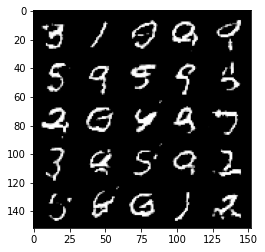

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


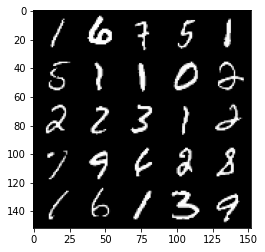

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Step 3: Generator loss: 1.9956450891494752, Discriminator loss: 1.9377554284334175


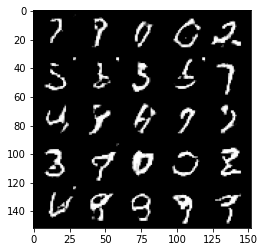

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


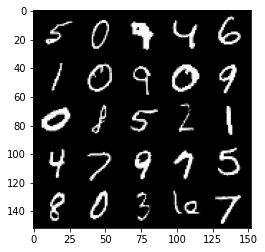

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Step 6: Generator loss: 1.9913661532402038, Discriminator loss: 1.9396474214792259


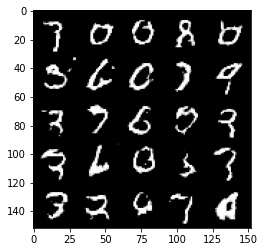

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


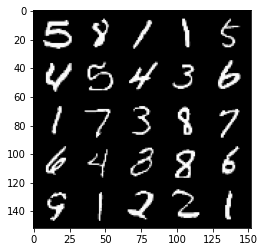

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Step 9: Generator loss: 1.9911786561012268, Discriminator loss: 1.9413020957708365


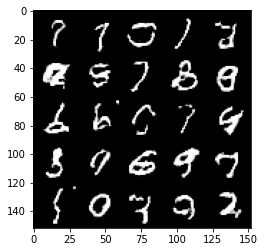

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


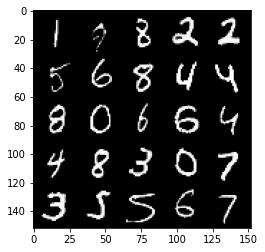

In [66]:
n_epochs = 10
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0

for epoch in range(n_epochs): # 기존에 100 epoch 수행
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)
        
        # Update disc
        disc_opt.zero_grad()
        latent = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(latent)
        disc_fake_pred = disc(fake)
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)    
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss)/2
        
        # track the average disc loss
        mean_discriminator_loss += disc_loss.item() /display_step
        disc_loss.backward(retain_graph=True)
        disc_opt.step() 
        
        # Update generator
        gen_opt.zero_grad()
        latent_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(latent_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        

        # track the average gen loss
        mean_generator_loss += gen_loss.item() / display_step
        gen_loss.backward()
        gen_opt.step()

        # visualize the results
    if epoch % 3 == 0:
      print(f"Step {epoch}: Generator loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
      fake_noise = get_noise(cur_batch_size, z_dim, device =device)
      fake = gen(fake_noise)
      show_tensor_images(fake)
      show_tensor_images(real)
      mean_generator_loss = 0
      mean_discriminator_loss = 0